In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds


In [4]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25861 sha256=6fca72ce826a0312e08d414465bffb0a34411e6fd9352f7a55ffa41f2c2c9b1a
  Stored in directory: /root/.cache/pip/wheels/35/e4/69/cb99d996d14a2971b79b990d68b05a17d58ce530ff96090dfc
Successfully built imutils


In [5]:
from tensorflow.keras.layers import Input, concatenate, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from skimage.transform import resize
import os
import csv
import PIL
import numpy as np
import random
import cv2
import imutils
import tensorflow.keras.backend as K
import tensorflow as tf
import pandas as pd
from skimage import io

In [6]:
INIT_LR = 0.0001
EPOCHS = 10
split = 0.8

In [7]:
####Specify your dataset path here####
train_df = pd.read_csv('/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train.csv',header=None)
test = pd.read_csv('/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_test.csv',header=None).rename(columns={0:'image', 1:'depth'})
train_df = train_df.sample(frac=1).reset_index(drop=True).rename(columns={0:'image', 1:'depth'})
train_split = int(len(train_df)*split)


train = train_df[:train_split]
validation = train_df[train_split:]
len(train), len(validation)

(40550, 10138)

In [8]:
##Change directory to the current dataset file path
import os 
os.chdir('/kaggle/input/nyu-depth-v2/nyu_data/')

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, dataframe, batch_size, shuffle=False, dim=(320,240)):
    # for reproducibility
    np.random.seed(43)
    # dataframe containing the subset of image and depth pairs
    self.df = dataframe
    # chosen Height and Width of the RGB image
    self.height, self.width = dim
    # choice of shuffling the data
    self.shuffle = shuffle
    self.batch_size = batch_size
    # unique set of RGB images
    self.ids = dataframe['image'].unique()
    # Map the image with depth maps
    self.imgtodpth = dataframe.set_index('image')['depth'].to_dict()
    self.on_epoch_end()

  def __len__(self):
    '''
    Returns the length of dataset.
    '''
    return len(self.df) // self.batch_size

  def on_epoch_end(self):
    '''
    Shuffles the data at the end of every epoch
    '''
    self.indexes = np.arange(len(self.ids))
    if self.shuffle:
      np.random.shuffle(self.indexes)
  
  def __getitem__(self,index):
    '''
    returns the batch of image and depth pairs 
    '''
    # select the batch of pair indexes 
    idxs = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
    # randomly select whether to flip the image
    flip = np.random.choice([False])
    # select the image id's for the above indexes
    query_imgs = [self.ids[idx] for idx in idxs]
    # select corresponding depth pair for the image
    target_imgs = [self.imgtodpth[img] for img in query_imgs]
    # preprocess the image 
    processed_query_img = self._preprocess_image(query_imgs, flip)
    # preprocess the depth map
    processed_depth_img = self._preprocess_depth(target_imgs, flip)
    return processed_query_img, processed_depth_img

  def _preprocess_image(self,images, flip):
    '''
    Resize, Normalize and randomly Augments the image set. 
    '''
    # placeholder for storing the processed images
    processed = []
    for img in images:
      # resize the image to 480,640
      resized_img = cv2.resize(io.imread(img),(self.width, self.height)).astype(np.float32)
      # normalize the image to {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # finally append each image
      processed.append(scaled_img)
    return np.array(processed)

  def _preprocess_depth(self,images, flip):
    '''
    Resize, Normalize and randomly Augments the depth maps.
    '''
    # placeholder for storing the processed depth maps
    processed = []
    for img in images:
      # resize the depth map to 320x240
      resized_img = cv2.resize(io.imread(img),(320,240)).astype(np.float32)
      # normalize it to range {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # add the color channel as cv2 grayscale image doesnt contain color channel but tensorflow expects it
      scaled_img = np.expand_dims(scaled_img, axis=-1)
      # finally append the image
      processed.append(scaled_img)
    return np.array(processed)
    

In [10]:
train_generator = DataGenerator(train, batch_size=8, shuffle=True, dim=(480,640))
val_generator = DataGenerator(validation, batch_size=8, shuffle=False, dim=(480,640))
test_generator = DataGenerator(test, batch_size=16, shuffle=False, dim=(480,640))
print(len(train_generator), len(val_generator), len(test_generator))

5068 1267 40


In [11]:
images,depths = next(iter(test_generator))
print(images.shape, depths.shape)

(16, 480, 640, 3) (16, 240, 320, 1)


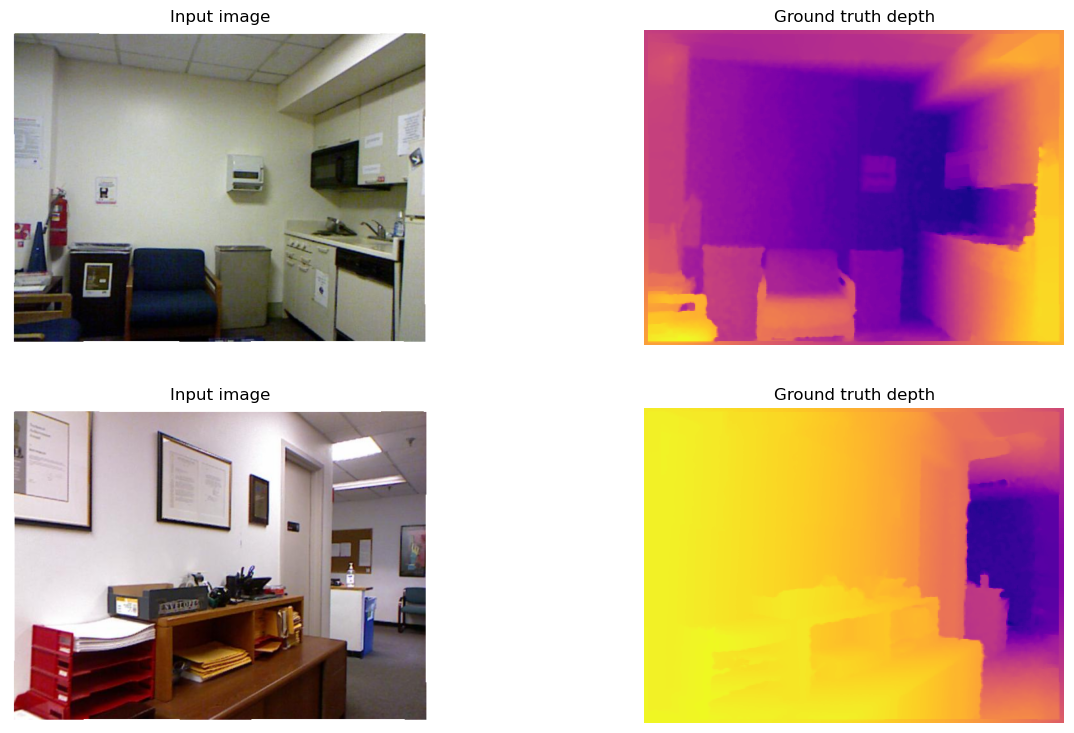

In [12]:
import matplotlib.pyplot as plt
cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,4,2):
  image = images[i]
  depth = depths[i].squeeze(-1)
  plt.subplot(221+i)
  plt.axis('off')
  plt.imshow(image)
  plt.title('Input image')
  plt.subplot(222+i)
  plt.axis('off')
  plt.imshow(depth,cmap=plt.get_cmap(cmap))
  plt.title('Ground truth depth')

In [7]:
from tensorflow.keras.applications import DenseNet169
# encoder
# Layer name of encoders to be concatenated
names = ['pool3_pool', 'pool2_pool', 'pool1','conv1/relu']
# Transfer learning approach without the classification head
encoder = DenseNet169(include_top=False, weights='imagenet', input_shape=(480,640,3))
for layer in encoder.layers:
  encoder.trainable = True
inputs = encoder.input

x = encoder.output

# bottleneck
conv5 = Conv2D(filters=1664, kernel_size=(1,1), padding='same')(x)
conv5 = LeakyReLU(alpha=0.2)(conv5)

def upsampling_block(input_tensor, n_filters, name, concat_with):
  x = UpSampling2D((2, 2), interpolation='bilinear', name=name)(input_tensor)

  x = concatenate([x, concat_with], axis=3)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convB")(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convC")(x)
  x = BatchNormalization()(x)
  return x

# decoder
conv6 = upsampling_block(conv5, 832, "up1", concat_with=encoder.get_layer(names[0]).output)
conv6 = LeakyReLU(alpha=0.2)(conv6)
conv7 = upsampling_block(conv6, 416, "up2", concat_with=encoder.get_layer(names[1]).output)
conv7 = LeakyReLU(alpha=0.2)(conv7)
conv8 = upsampling_block(conv7, 208, "up3", concat_with=encoder.get_layer(names[2]).output)
conv8 = LeakyReLU(alpha=0.2)(conv8)
conv9 = upsampling_block(conv8, 104, "up4", concat_with=encoder.get_layer(names[3]).output)

  # output
o = Conv2D(filters=1, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', name='conv10')(conv9)

model = Model(inputs=inputs, outputs=o)


51877672/51877672 [==============================] - 0s 0us/step


In [ ]:
print("Number of layers in the base model: ", len(encoder.layers))

In [ ]:
model.summary()

In [ ]:
#from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=False, dpi=96)

In [12]:
!pip install tensorflow_addons

In [11]:
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0
  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

opt = tfa.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=1e-6, amsgrad=True)

# custom loss
import tensorflow as tf
from tensorflow.keras import backend as K

def depth_loss(y_true, y_pred):
 #Cosine distance loss
  l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
  
  # edge loss for sharp edges
  dy_true, dx_true = tf.image.image_gradients(y_true)
  dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
  
  # structural similarity loss
  l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  # weightage
  w1, w2, w3 = 1.0, 1.0, 0.1
  return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))


#custom soft accuracy
def depth_acc(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


def structural_similarity_index(y_true, y_pred, max_val=1.0):
    # Compute the SSIM index between the predicted and ground truth images
    ssim_index = tf.image.ssim(y_true, y_pred, max_val=max_val)
    # Return the SSIM index as a scalar value
    return ssim_index

checkpoint_path = "/kaggle/working/Checkpoint_Dense_Net/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 verbose=1)
#
callbacks = [LearningRateScheduler(poly_decay, verbose=1), cp_callback]
     

In [12]:
from keras.models import load_model
model = load_model('/kaggle/input/densenet-model/Depth_Unet_transferlearning_final', custom_objects = {'depth_loss':depth_loss, 'depth_acc':[depth_acc, rmse,structural_similarity_index, 'mae', 'mse']})

In [13]:
model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc,structural_similarity_index, rmse, 'mae', 'mse'])
     

In [ ]:
##Uncomment if loading a pre trained model
#checkpoint_path = "/kaggle/working/Checkpoint_Dense_Net/cp.ckpt"
#model.load_weights(checkpoint_path)

In [ ]:

# Train the model with the new callback
m = model.fit(train_generator, validation_data=val_generator, epochs=10,callbacks=callbacks)
# Pass callback to training
os.listdir(checkpoint_dir)

In [ ]:
plt.style.use('ggplot')

plt.plot(m.history['loss'], label='loss')
plt.plot(m.history['val_loss'], label='val_loss')

plt.plot(m.history['depth_acc'], label='acc')
plt.plot(m.history['val_depth_acc'], label='val_acc')

plt.legend()
plt.show()

In [15]:
model.evaluate(test_generator)

40/40 [==============================] - 40s 880ms/step - loss: 0.0946 - depth_acc: 0.8583 - structural_similarity_index: 0.8482 - rmse: 0.1327 - mae: 0.0997 - mse: 0.0181


[0.09457661211490631,
 0.8582652807235718,
 0.8482334017753601,
 0.13273675739765167,
 0.09974810481071472,
 0.018101457506418228]

In [ ]:
images,labels = next(iter(test_generator))
preds = model.predict(images)
cmap = "plasma_r"


for i in range(10):
  plt.figure(figsize=(19,10))
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)
  plt.subplot(1,3,1)
  plt.axis("off")
  plt.imshow(pred, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,2)
  plt.axis("off")
  img = labels[i]
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,3)
  plt.axis("off")
  img1 = images[i]
  plt.imshow(img1)

  plt.show()